In [131]:
import gc
gc.collect()

5076

In [132]:
# Import comet_ml at the top of your file
# from comet_ml import Experiment


from matplotlib import pyplot as plt
# from matplotlib import style
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import swifter
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras as k
import tensorflow as tf
# import torch
from scipy import stats
import nltk



# Create an experiment with your api key
# experiment = Experiment(
#     api_key="BKac2uRt0FMAlheXf6HClaZhD",
#     project_name="general",
#     workspace="sarthak7034",
# )


In [133]:
nltk.download('stopwords')
stop_words = stopwords.words('english') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('gpu')))
# torch.cuda.is_available()

Num GPUs Available:  0


In [135]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [136]:
# experiment.end()

In [137]:
#Read dataset
data = pd.read_csv("./all_data.csv").drop("Unnamed: 0", axis=1)

## Cleaning Text

In [138]:
# stop_words = stop_words.remove('not')
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]     # Experiment with removing it!!!
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

scaler = MinMaxScaler()

In [139]:
#Applying lamdba function to clean text
data['text'] = data.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
data['title'] = data.swifter.apply(lambda row: clean_text(row['title']), axis=1)


Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

In [140]:
#Replacing row with only text
data = data[data['title'].str.len() >= 1]
data = data[data['text'].str.len() >= 1]

In [141]:
# df1 = data.loc[:,['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

# # Zero Score Dataframe Normalization
# MaxMin_df = stats.zscore(df1)
# MaxMin_df.head()

In [142]:
#Displaying the new dataset which we will be working with
df2 = data.loc[:,['title','text','type']]

In [143]:
# Whether any values are missing
# df2.isnull().sum()
# df1.isnull().sum()

In [144]:
df2 = df2[df2['text'].map(len) >= 1]
#Reset index
df2 = df2.reset_index().drop("index", axis=1)
df2


,title,text,type
0,"[At, Donald, Trump, Properties, Showcase, Bran...","[They, stood, line, Trump, Tower, sometimes, h...",real
1,"[Trump, Foundation, Tells, New, York, It, Has,...","[Donald, J, Trump, foundation, informed, Attor...",real
2,"[Donald, Trump, Prepares, White, House, Move, ...","[President, Donald, J, Trump, White, House, ou...",real
3,"[Luring, Chinese, Investors, With, Trump, Name...","[An, investment, pitch, new, Texas, hotel, try...",real
4,"[Melania, Barron, Trump, Won, Immediately, Mov...","[President, Donald, J, Trump, wife, Melania, s...",real
...,...,...,...
19800,"[Alabama, Lawmaker, Same, Couples, Don, Deserv...","[Most, conservatives, oppose, marriage, equali...",real
19801,"[GOP, Senator, David, Perdue, Jokes, About, Pr...","[The, freshman, senator, Georgia, quoted, scri...",real
19802,"[State, Department, says, find, emails, Clinto...","[The, State, Department, told, Republican, Nat...",real
19803,"[In, Ethiopia, Obama, seeks, progress, peace, ...","[ADDIS, ABABA, Ethiopia, Obama, convened, meet...",real


type
fake    11731
real     8074
Name: title, dtype: int64


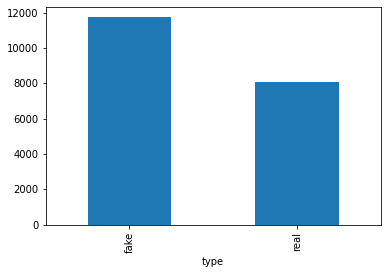

In [145]:
# How many fake and real articles?
print(df2.groupby(['type'])['title'].count())
df2.groupby(['type'])['title'].count().plot(kind="bar")
plt.show()

## Word2Vec

In [146]:
model_embed = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin.gz",binary=True)

In [147]:
vocab_length = len(model_embed.key_to_index.keys())
print(vocab_length)                                         #Input dimension size(3000000)

3000000


In [148]:
# Applying it to the columns 

df2['title'] = df2.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['title'] if x in model_embed.key_to_index], axis=1)
df2['text'] = df2.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['text'] if x in model_embed.key_to_index], axis=1)


Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

In [149]:
# One-hot encoding
encoder = LabelBinarizer().fit(list(df2['type']))
df2['type'] = df2.swifter.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

In [150]:
# Shifting all to a new dataframe
df3 = df2.loc[:,['title','text','type']]

## Padding

### Method 1

In [151]:

# def pad_array(array, token_len):
#     diff_token = token_len - len(array)
#     if(diff_token < 0):
#         array = array[:token_len] 
#     else:
#         array += [0]*diff_token 
        
#     return array 

# tokens_numbers_text = df2.swifter.apply(lambda row: len(row['text']), axis = 1)
# max_tokens_text = int(np.mean(tokens_numbers_text) + 2 * np.std(tokens_numbers_text))

# tokens_numbers_title = df2.swifter.apply(lambda row: len(row['title']), axis = 1)
# max_tokens_title = int(np.mean(tokens_numbers_title) + 2 * np.std(tokens_numbers_title))
# print(max_tokens_text,max_tokens_title)    

# df3['text'] = df2.swifter.apply(lambda r: pad_array(r['text'], max_tokens_text) , axis=1)
# df3['title'] = df2.swifter.apply(lambda r: pad_array(r['title'], max_tokens_title) , axis=1)




### Method 2

In [152]:
# Check the highest length of text and title:
max_tokens_text = 13000
max_tokens_title = 48

df3['text'] = list(pad_sequences((df2['text']), maxlen=max_tokens_text,padding='post'))
df3['title'] = list(pad_sequences(df2['title'], maxlen=max_tokens_title,padding='post'))

# Building Model

## Saving it as Pickle 

In [153]:
#Python object serialized
df3.to_pickle('./model_data.pickle')

In [154]:
data_pickle = pd.read_pickle('./model_data.pickle')
data_pickle = data_pickle.dropna()

In [155]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data_pickle[['text', 'title']], data_pickle['type'], test_size=0.2, random_state=42)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
 

train_fit = [np.asarray(X_train['title'].tolist()), 
             np.asarray(X_train['text'].tolist())
             ]

valid_fit = [np.asarray(X_valid['title'].tolist()), 
             np.asarray(X_valid['text'].tolist())
             ]

test_fit = [np.asarray(X_test['title'].tolist()), 
             np.asarray(X_test['text'].tolist())
             ]    


In [163]:
from numpy.random import seed

seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

## Binary_crossentropy

In [164]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
# inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300)(title_input)
inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)

#Added
x1 = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu')(inp1)
x1 = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x1)
x1 = k.layers.Flatten()(x1)
x1 = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x1)

#input_Text
text_input = k.layers.Input(shape=(max_tokens_text,))
# inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300)(text_input)
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(text_input)

x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Text')(x2)


#Merge
x = k.layers.concatenate([x1, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
model = k.models.Model(inputs=[title_input, text_input], outputs=[out])

model.compile(k.optimizers.Nadam(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13000)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 300)      900000000   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13000, 300)   900000000   ['input_2[0][0]']                
                                                                                              

## Categorical_crossentropy

In [165]:
# #input_title
# title_input = k.layers.Input(shape=(max_tokens_title,))
# inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)

# x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu')(inp1)
# x = k.layers.MaxPool1D(pool_size = 2)(x)
# x = k.layers.Flatten()(x)
# x = k.layers.Dense(50, activation='relu',  kernel_regularizer='l2')(x)

# #input_content
# text_input = k.layers.Input(shape=(max_tokens_text,))
# inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(text_input)

# x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu')(inp2)
# x2 = k.layers.MaxPool1D(pool_size = 4 )(x2)

# #Added
# x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu')(inp2)
# x2 = k.layers.MaxPool1D(pool_size = 4, )(x2)
# x2 = k.layers.Flatten()(x2)
# x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2')(x2)


# #Merge
# x = k.layers.concatenate([x, x2])

# #Common part
# x = k.layers.Dense(50, activation='relu')(x)
# x = k.layers.Dropout(0.2)(x)
# x = k.layers.Dense(50, activation='relu')(x)
# x = k.layers.Dropout(0.2)(x)
# out = k.layers.Dense(4, activation='softmax')(x)


# #Build model
# model = k.models.Model(inputs=[title_input, text_input], outputs=[out])

# model.compile(k.optimizers.RMSprop(), loss='sparse_categorical_crossentropy', metrics=['acc'])

# model.summary()

## Fitting the Model

In [166]:
history = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=4)], 
        validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/20
100/100 [==============================] - 302s 3s/step - loss: 1.0038 - acc: 0.7038 - val_loss: 0.6280 - val_acc: 0.8299
Epoch 2/20
100/100 [==============================] - 300s 3s/step - loss: 0.5092 - acc: 0.8518 - val_loss: 0.4730 - val_acc: 0.8447
Epoch 3/20
100/100 [==============================] - 300s 3s/step - loss: 0.4959 - acc: 0.8811 - val_loss: 1.4863 - val_acc: 0.6589
Epoch 4/20
100/100 [==============================] - 300s 3s/step - loss: 0.5696 - acc: 0.9034 - val_loss: 0.5262 - val_acc: 0.8741
Epoch 5/20
100/100 [==============================] - 301s 3s/step - loss: 0.3958 - acc: 0.9398 - val_loss: 0.4401 - val_acc: 0.8959
Epoch 6/20
100/100 [==============================] - 302s 3s/step - loss: 0.2354 - acc: 0.9718 - val_loss: 0.4278 - val_acc: 0.8700
Epoch 7/20
100/100 [==============================] - 303s 3s/step - loss: 0.1451 - acc: 0.9886 - val_loss: 0.3780 - val_acc: 0.9006
Epoch 8/20
100/100 [==============================] - 299s 3s/step - 

In [167]:
test_pred = model.predict(test_fit)

In [168]:
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.9136581671295128

In [169]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2374
           1       0.90      0.88      0.89      1587

    accuracy                           0.91      3961
   macro avg       0.91      0.91      0.91      3961
weighted avg       0.91      0.91      0.91      3961

